## Importing Packages

In [1]:
from tensorflow.keras import Model as Model_
from tensorflow.keras.layers import Input, ReLU, LSTM, GRU, SimpleRNN, Dense, TimeDistributed, Bidirectional, GaussianNoise 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, model_from_json
import tensorflow as tf
import tensorflow_model_remediation.min_diff.losses.mmd_loss as MMD

import matplotlib.pyplot as plt
from itertools import chain
import pandas as pd
import numpy as np
import imageio
import os
import re

print(tf.__version__)

2.7.0


## Dataset Reading and Preprocessing

### Listing all the movable joints in the human skeleton

In [2]:
#Was done in the preprocessing in [1]
# Joints in H3.6M -- data has 32 joints, but only 17 that move; these are the indices.
H36M_NAMES = ['']*32
H36M_NAMES[0]  = 'Hip'
H36M_NAMES[1]  = 'RHip'
H36M_NAMES[2]  = 'RKnee'
H36M_NAMES[3]  = 'RFoot'
H36M_NAMES[6]  = 'LHip'
H36M_NAMES[7]  = 'LKnee'
H36M_NAMES[8]  = 'LFoot'
H36M_NAMES[12] = 'Spine'
H36M_NAMES[13] = 'Thorax'
H36M_NAMES[14] = 'Neck/Nose'
H36M_NAMES[15] = 'Head'
H36M_NAMES[17] = 'LShoulder'
H36M_NAMES[18] = 'LElbow'
H36M_NAMES[19] = 'LWrist'
H36M_NAMES[25] = 'RShoulder'
H36M_NAMES[26] = 'RElbow'
H36M_NAMES[27] = 'RWrist'

### A class to Read and Combine all the Dataset files

In [3]:
class Dataset_loading:
    def __init__(self, dir_path, include_dimension = 2, sample_size = 50, 
                 total_classes = 17, datatype = 'float32', include_movable_joints = False, batch_size = 20, 
                 include_action_labels = True, return_action_labels = False):
        
        #Dataset Directory path
        self.dir_path = dir_path
        
        #Which Dimension file to include, possible values: 2 and 3
        self.include_dimension = include_dimension
        
        #Total frames in one Sample
        self.sample_size = sample_size
        
        #Default Datatype for all the samples
        self.datatype = datatype
        
        #Batch Size of the dataset for experimentation 
        self.batch_size = batch_size
        
        #Boolean value to indicate whether to include action class in each frames
        self.include_action_labels = include_action_labels
        
        #Whether to return action labels with data
        self.return_action_labels = return_action_labels
        
        #Activity classes to include
        self.classes = ['SittingDown', 'Walking', 'Directions', 'Discussion', 'Sitting', 'Phoning', 'Eating', 'Posing', 'Greeting', 'Smoking']
        
        #Total activity classes
        self.total_classes = len(self.classes)
        
        #Subject Folders names in the Dataset
        self.internal_folders = ['S1', 'S5','S6','S7','S8','S9','S11']

        #Boolean value indicating whether to include all joints or only the movable joints.
        self.include_movable_joints = include_movable_joints
        
        self.movable_joints = [0, 1, 2, 3, 6, 7, 8, 12, 13, 14, 15, 17, 18, 19, 25, 26, 27]
    
    def read_dataset(self):
        try:
            #Contains all the different activity vectors
            activity_vector = {}
            
            #Contains the overall dataset
            sampled_data = None
            sampled_labels = None
            
            #Based on dimensions, which folder to use for extracting the dataset files
            data_folder = 'Poses_D2_Positions' if self.include_dimension == 2 else 'Poses_D3_Positions'
            
            #Checking if the dataset path is valid
            if not os.path.exists(self.dir_path):
                print('The Data Directory Does not Exist!')
                return None

            #Iterating over all the subject folders
            for fld in self.internal_folders:
                #Iterating for each file in the specified folder
                for file in os.listdir(os.path.join(self.dir_path, fld, data_folder)):
                    #Extracting the activity from the filename
                    activity = self.__extract_activity(file)
                    
                    if activity not in self.classes:
                        continue
                    
                    #Reading the CSV file using Pandas
                    data = pd.read_csv(os.path.join(self.dir_path, fld, data_folder, file), header=None)

                    #Formulating the activity vector using one hot encoding
                    if activity not in activity_vector:
                        total_keys = len(activity_vector.keys())
                        activity_vector[activity] = np.zeros(self.total_classes)
                        activity_vector[activity][total_keys] = 1
                    vector = activity_vector[activity]
                    
                    #Sampling the dataset
                    grouped_sample, grouped_activity = self.__group_samples(data, self.sample_size, vector)
                    sampled_data = grouped_sample if sampled_data is None else np.append(sampled_data, grouped_sample, axis=0)
                    sampled_labels = grouped_activity if sampled_labels is None else np.append(sampled_labels, grouped_activity, axis=0)
            
            #Changing the Datatype
            sampled_data = sampled_data.astype(self.datatype)
            
            #To make the data divisible for batch size
            total_batches = sampled_data.shape[0]
            sampled_data = sampled_data[:total_batches - (total_batches % self.batch_size)]
            sampled_labels = sampled_labels[:total_batches - (total_batches % self.batch_size)]
            
            if self.return_action_labels:
                return sampled_data, sampled_labels
            
            return sampled_data
        except Exception as e:
            print(e)
    
    def __extract_activity(self, filename):
        try:
            #Extracting the filename and excluding the extension
            name = os.path.splitext(filename)[0]
            
            #Substituting the empty string with characters other than english alphabets
            activity = re.sub('[^A-Za-z]+' , '' , name)
            return activity
        except Exception as e:
            print(e)
    
    def __group_samples(self, dataset, sample_size, activity):
        try:
            #Checking if the dataset is a Pandas Dataframe
            if not isinstance(dataset, pd.DataFrame):
                print('Expecting Pandas Dataframe, but got {}'.format(type(dataset)))
                return None
            
            if self.include_movable_joints:
                joints = list(chain.from_iterable((jt*2, (jt*2)+1) for jt in self.movable_joints))
                dataset = dataset.iloc[: , joints].copy()

            #Appending activity class to each row in the dataset
            if self.include_action_labels:
                dataset = pd.concat([dataset, pd.DataFrame(np.tile(activity, (dataset.shape[0],1)))], axis=1)
            
            #Reshaping the dataset into sample batches
            total_samples = dataset.shape[0]//sample_size
            total_features = dataset.shape[1]
            grouped_rows = dataset.to_numpy()[:total_samples*self.sample_size].reshape((-1,self.sample_size, total_features))
            
            grouped_activity = np.tile(activity, (dataset.shape[0]//self.sample_size, 1))
            grouped_activity = grouped_activity[:total_samples*self.sample_size].reshape((-1, len(activity)))
            
            return grouped_rows, grouped_activity
        except Exception as e:
            print(e)

### A function to split Dataset into Features and Labels

In [4]:
def split_to_features_labels(dataset, input_sequance_size=10, total_features=64):
    """
    Function for splitting the data into features(with sequance size=iput_sequance_size)
    and labels which should be the remainder of the sample length 
    """
    assert input_sequance_size < dataset.shape[1], f"input sequence should be smaller than the total sample size"
    
    #Dividing the dataset into features and labels by splitting the Time Frame Dimension
    features = dataset[:, np.s_[0:input_sequance_size], :]
    labels = dataset[:,np.s_[input_sequance_size:], :total_features]
    
    return features, labels

### A function for downsampling the dataset on number of frames

In [5]:
def downsampling(sampled_data, downsample_technique = 'skip'):
    """
    The function used to down-sample the data using two different techniques. In Skip, one frame is skipped consecutively and
    in the mean technique, two frames are averaged consecutively.
    """
    
    assert downsample_technique in ['skip', 'mean'], f"Only Skip and Mean techniques are available"
    
    #Creating an empty variable to store Downsampled data when the technique is Mean
    samples_per_batch = int(sampled_data.shape[1] / 2)
    total_features = sampled_data.shape[2]
    downsampled_data = np.empty(shape=(0, samples_per_batch, total_features))
    
    #In Skip technique, we skip 2 frames consecutively.
    if downsample_technique == 'skip':
        downsampled_data = sampled_data[:,::2,:]
    else:
        #Iterating over batches
        for batch in sampled_data:
    
            averaged_batch = np.empty(shape=(0, total_features))
    
            #In each iteration, averaging 2 Frames and appending it to the variable
            for i in range(0, batch.shape[0], 2):
                averaged_batch = np.append(averaged_batch, np.mean(batch[i:i+2, :], axis = 0).reshape((1, total_features)), axis = 0)
            
            #Appending the whole batched averaged downsampled data to the new variable created before
            downsampled_data = np.append(downsampled_data, averaged_batch.reshape((1, samples_per_batch, total_features)), axis = 0)
    
    return downsampled_data

### Adding more preprocessing steps (Normalization and gussian noise)

In [91]:
def preprocess_data(sampled_dataX, sampled_dataY, normalize=True, add_noise=True
                    , stddev=0.05, augmentation = False) :
    """
    Function to preprocess data by normalizing input features and adding guassian
    noise to increase model robustness
    """
    original_sampled_dataX = sampled_dataX.copy()
    class_labels = sampled_dataX[:, :, -10:]
    sampled_dataX = sampled_dataX[:,:,:-10]
    
    if normalize :
        sampled_dataX =  tf.keras.utils.normalize(sampled_dataX, axis=2)
    
    if add_noise :
        guassian_noise_layer = tf.keras.layers.GaussianNoise(stddev=stddev)
        sampled_dataX = guassian_noise_layer(sampled_dataX)
        
    sampled_dataX = np.append(sampled_dataX, class_labels, axis=2)
    
    if augmentation:
        sampled_dataX = np.append(original_sampled_dataX, sampled_dataX, axis=0)
        sampled_dataY = np.append(sampled_dataY, sampled_dataY, axis=0)
    
    return sampled_dataX, sampled_dataY

## Defining different components of the model

### DLinear Model class

In [115]:
class SeriesDecomp():
    """
    Series decomposition into seasonal and trend components
    """

    def __init__(self, kernel_size):
        self.kernel_size = kernel_size

    def forward(self, x): 
        x_tf = tf.transpose(x, [0, 2, 1])
        
        avg_pool_1d = tf.keras.layers.AveragePooling1D(pool_size=self.kernel_size, strides=1, padding='same')
        trend = tf.transpose(avg_pool_1d(x_tf), [0, 2, 1])
        return trend, tf.subtract(x, tf.cast(trend, x.dtype))
    
class Dlinear(Model_):

    def __init__(self,  output_len=20):
        super(Dlinear, self).__init__()
       
        self.output_len = output_len
        # Decompsition Kernel Size
        kernel_size = 25
        
        self.decomp = SeriesDecomp(kernel_size)
        # season layer
        self.Linear_Seasonal = tf.keras.models.Sequential([tf.keras.layers.Dense(self.output_len)])
        # trend layer
        self.Linear_Trend = tf.keras.models.Sequential([tf.keras.layers.Dense(self.output_len)])


    def call(self, inputs):
        '''
        :param inputs: 
        :return: prediction output
        '''
        seasonal_init, trend_init = self.decomp.forward(inputs)
        seasonal_init = tf.transpose(seasonal_init, [0, 2, 1])
        trend_init = tf.transpose(trend_init, [0, 2, 1])
        
        # model linear layers for seasonal and trend components
        seasonal_output = self.Linear_Seasonal(seasonal_init)
        trend_output = self.Linear_Trend(trend_init)
        
        # adding both components prediction
        final_output = seasonal_output + trend_output
        return tf.transpose(final_output, [0, 2, 1])

### Defining different Types of Loss functions

In [8]:
class Loss() :
    """
    Joint loss class with two weight attributes for two different losses
    first one is the loss joint and the second is the loss_motion_flow
    """
    
    def __init__(self, lambda1=0.5, lambda2=0.5) :
        self.lambda1 = lambda1
        self.lambda2 = lambda2

    def loss_joint(self, predicted_sequance_batch, target_sequance_batch) :
        """
        Loss between the joint positions and its corresponding counterparts in the groundtruth
        """
        diff_norm_2 = tf.math.reduce_sum(tf.square(tf.subtract(predicted_sequance_batch, target_sequance_batch)), axis=2)
        return tf.reduce_sum(diff_norm_2, axis=1) 

    def loss_motion_flow(self, predicted_sequance_batch, target_sequance_batch) :
        """
        Loss between the motion flow of predicted sequance and the ground truth
        where the motion flow is the euclidean distance between each two consecutive frames
        """
        predictions_tomporal_diffs = tf.experimental.numpy.diff(predicted_sequance_batch, axis=1)
        real_tomporal_diffs = tf.experimental.numpy.diff(target_sequance_batch, axis=1)
        prediction_motion_flow_diff_norm_2 = tf.reduce_sum(tf.square(tf.subtract(predictions_tomporal_diffs, real_tomporal_diffs)), axis=2)
        return tf.reduce_sum(prediction_motion_flow_diff_norm_2, axis=1)

    def total_loss(self, target_sequance_batch, predicted_sequance_batch) :
        """
        calculating the total loss through a combination of the joint_loss and motion_flow_loss
        """
        joints_loss = self.loss_joint(predicted_sequance_batch, target_sequance_batch)
        motion_flow_loss = self.loss_motion_flow(predicted_sequance_batch, target_sequance_batch)
        return self.lambda1*joints_loss + self.lambda2*motion_flow_loss

### Defining different types of Evaluation Metrics

In [9]:
class Metrics():
    """
    A class containing different types of Evaluation Metrics.
    """
    
    def __init__(self, mmd_kernel='gaussian') :
        self.mmd_kernel = mmd_kernel
    
    def custom_sequence_MMD_loss(self, target_sequance_batch, predicted_sequance_batch):
        """
        Calculating the Sequence MMD Loss between prediction and the ground Truth.
        Additionally combining the last two dimensions 
        """
        mmd_loss = MMD.MMDLoss(kernel=self.mmd_kernel)
        
        total_batches = predicted_sequance_batch.shape[0]
        frames_per_batch = predicted_sequance_batch.shape[1] * predicted_sequance_batch.shape[2]
        
        return mmd_loss(tf.reshape(predicted_sequance_batch, [total_batches, frames_per_batch]),
                        tf.reshape(target_sequance_batch, [total_batches, frames_per_batch]))
        
    def MPJPE2(self, y_true, y_pred, number_of_joints = 32):
        """
        Calculating the Mean Per Joint Position Error (MPJPE) between prediction and the ground Truth.
        """
        yt= y_true.reshape((-1,number_of_joints,2))
        yp= y_pred.reshape((-1,number_of_joints,2))
        dist= np.zeros(yt.shape[0])
        
        for i in range(yt.shape[0]):
            dist[i] = np.linalg.norm(yt[i] - yp[i])
        
        return np.mean(dist)
    
    def NPSS(self, euler_gt_sequences, euler_pred_sequences):
        """
        A function to compute the Normalized Power Spectrum Similarity (NPSS) metric between predictions and the ground Truth [2] and [3].
        """        
        # computing 1) fourier coeffs 2)power of fft 3) normalizing power of fft dim-wise 4) cumsum over freq. 5) EMD 
        gt_fourier_coeffs = np.zeros(euler_gt_sequences.shape, dtype = 'complex_')
        pred_fourier_coeffs = np.zeros(euler_pred_sequences.shape, dtype = 'complex_')

        # power vars
        gt_power = np.zeros((gt_fourier_coeffs.shape))
        pred_power = np.zeros((gt_fourier_coeffs.shape))

        # normalizing power vars
        gt_norm_power = np.zeros(gt_fourier_coeffs.shape)
        pred_norm_power = np.zeros(gt_fourier_coeffs.shape)

        cdf_gt_power = np.zeros(gt_norm_power.shape)
        cdf_pred_power = np.zeros(pred_norm_power.shape)

        emd = np.zeros(cdf_pred_power.shape[0:3:2])

        # used to store powers of feature_dims and sequences used for avg later
        seq_feature_power = np.zeros(euler_gt_sequences.shape[0:3:2])
        power_weighted_emd = 0

        for s in range(euler_gt_sequences.shape[0]):

            for d in range(euler_gt_sequences.shape[2]):
                gt_fourier_coeffs[s,:,d] = np.fft.fft(euler_gt_sequences[s,:,d]) # slice is 1D array
                pred_fourier_coeffs[s,:,d] = np.fft.fft(euler_pred_sequences[s,:,d])

                # computing power of fft per sequence per dim
                gt_power[s,:,d] = np.square(np.absolute(gt_fourier_coeffs[s,:,d]))
                pred_power[s,:,d] = np.square(np.absolute(pred_fourier_coeffs[s,:,d]))

                # matching power of gt and pred sequences
                gt_total_power = np.sum(gt_power[s,:,d])
                pred_total_power = np.sum(pred_power[s,:,d])
                #power_diff = gt_total_power - pred_total_power

                # adding power diff to zero freq of pred seq
                #pred_power[s,0,d] = pred_power[s,0,d] + power_diff

                # computing seq_power and feature_dims power 
                seq_feature_power[s,d] = gt_total_power

                # normalizing power per sequence per dim
                if gt_total_power != 0:
                    gt_norm_power[s,:,d] = gt_power[s,:,d] / gt_total_power 

                if pred_total_power !=0:
                    pred_norm_power[s,:,d] = pred_power[s,:,d] / pred_total_power

                # computing cumsum over freq
                cdf_gt_power[s,:,d] = np.cumsum(gt_norm_power[s,:,d]) # slice is 1D
                cdf_pred_power[s,:,d] = np.cumsum(pred_norm_power[s,:,d])

                # computing EMD 
                emd[s,d] = np.linalg.norm((cdf_pred_power[s,:,d] - cdf_gt_power[s,:,d]), ord=1)

        # computing weighted emd (by sequence and feature powers)
        power_weighted_emd = np.average(emd, weights=seq_feature_power) 

        return power_weighted_emd

### A function to start the experiment of training and evaluating the model

In [10]:
def run_experiment_Dliner(sampled_dataX, sampled_dataY, learning_rate=0.002, lambda1=0.5,
                   lambda2=0.5, use_mse=False, use_MMD=False, metrics=None, output_diminsion=64,
                   batch_size=100, epochs=50, validation_split=0.2) :
    """
    Method takes all hyperparameters as input paramters and returns the model and history as
    a result
    """

    dliner_model = Dlinear(output_diminsion)

    if use_mse :
        loss_function = tf.keras.losses.mean_squared_error
    elif use_MMD :
        loss_function = Loss().custom_sequence_MMD_loss
    else :
        loss_function = Loss(lambda1=lambda1, lambda2=lambda2).total_loss

    dliner_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=loss_function,metrics=metrics, run_eagerly=False)
    with tf.device('/gpu:0'):
        history = dliner_model.fit(sampled_dataX, sampled_dataY, batch_size=batch_size, 
                               epochs=epochs, validation_split=validation_split)
    return history, dliner_model

### Functions to visualize certain frames from the Dataset

In [11]:
def create_gif(lenght = 10, path_to_save = ''):
    """
    Function to create and save a GIF from different number of frames
    """
    list=[]
    for l in range(lenght):
        list.append(f'{path_to_save}_frame{l}.png')

    with imageio.get_writer(f'{path_to_save}.gif', mode='I', duration=0.1) as writer:
        for filename in list:
            image = imageio.imread(filename)
            writer.append_data(image)

In [12]:
def visualize_frames(sample, dynamic_joints_only=False, num_frames_to_visualize=10, 
                    path_to_save="", save_gif=False,
                    joints_to_ignore=[4,5,9,10,11,16,20,21,22,23,24,28,29,30,31]) :
    """
    Visualization function to draw a certain number of frames in a given sample
    ignoring the joints mentioned in joints_to_ignore array
    """
    assert num_frames_to_visualize <= sample.shape[0], f"number of frames should be less than or equal to the total frames in the sample"
    
    fig, axs = plt.subplots(ncols=num_frames_to_visualize, figsize=(40, 10))
    fig.tight_layout(pad=1.0)
    
    for t in range(num_frames_to_visualize) :
        #Removing unnecessary joints for visualization
        if(dynamic_joints_only) :
            #Check if no joints needs to be removed
            truncated_frame = sample[t]
        else :
            #Removing the joints based on joints_to_ignore
            joints_to_ignore_2d = [element * 2 for element in joints_to_ignore]
            for i in range(len(joints_to_ignore_2d)) :
                joints_to_ignore_2d.append(joints_to_ignore_2d[i]+1)
            truncated_frame = np.delete(sample[t], joints_to_ignore_2d)   

        #In case of including only moving joints for Human3.6M(17 joints)      
        x_axis_array = truncated_frame[0:34:2]
        y_axis_array = truncated_frame[1:35:2]
        #Scattering all the 17 joints
        axs[t].scatter(x_axis_array, y_axis_array)
        #Plotting right leg
        axs[t].plot(x_axis_array[:4], y_axis_array[:4], "tab:blue")
        #plotting left leg
        axs[t].plot(x_axis_array[[0, 4, 5, 6]], y_axis_array[[0, 4, 5, 6]])
        #plotting from hip to head
        axs[t].plot(x_axis_array[[0, 7, 8, 9, 10]], y_axis_array[[0, 7, 8, 9, 10]])
        #plotting from neck to left shoulder
        axs[t].plot(x_axis_array[[9, 11, 12, 13]], y_axis_array[[9, 11, 12, 13]])
        #plotting from neck to right shoulder
        axs[t].plot(x_axis_array[[9, 14, 15, 16]], y_axis_array[[9, 14, 15, 16]])
        axs[t].invert_yaxis()
        axs[t].set_xticks([])
        axs[t].set_yticks([])
        
        if(len(path_to_save) > 0) :
            extent = axs[t].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            fig.savefig(f'{path_to_save}_frame{t}.png', bbox_inches=extent)
    
    if save_gif==True:
        create_gif(lenght=num_frames_to_visualize,path_to_save=path_to_save)

    plt.show()

## Experimentations

### Reading and Preprocessing the Dataset

In [66]:
#Reading the whole dataset for shortterm predictions
sampled_data_short_term = Dataset_loading('../H3.6csv', sample_size=40, include_movable_joints=False).read_dataset()

In [67]:
#Reading only the movable dataset points for shortterm predictions
sampled_data_short_term_movable = Dataset_loading('../H3.6csv', sample_size=40, include_movable_joints=True).read_dataset()

In [68]:
#For long term prediction, we need a sample size of 60(10 frames input sequance, 50 frames predicted sequance)
sampled_data_all = Dataset_loading('..\H3.6csv', sample_size=60, include_movable_joints=False).read_dataset()

In [69]:
#For long term movable joints prediction, we need a sample size of 60(10 frames input sequance, 50 frames predicted sequance)
sampled_data_movable = Dataset_loading('..\H3.6csv', sample_size=60, include_movable_joints=True).read_dataset()

### Splitting the Dataset into Features and Labels

In [70]:
sampled_dataX_all, sampled_dataY_all = split_to_features_labels(sampled_data_all, input_sequance_size=10, total_features=64)

In [71]:
sampled_dataX_movable, sampled_dataY_movable = split_to_features_labels(sampled_data_movable, input_sequance_size=10, total_features=34)

In [72]:
sampled_dataX_short_term, sampled_dataY_short_term = split_to_features_labels(sampled_data_short_term, input_sequance_size=10, total_features=64)

In [73]:
sampled_dataX_short_term_movable, sampled_dataY_short_term_movable = split_to_features_labels(sampled_data_short_term_movable, input_sequance_size=10, total_features=34)

In [74]:
print('Dataset with all features(short term)')
print('Total Samples: {}\nTotal Frames: {}\nTotal Features: {}'.format(sampled_dataY_short_term.shape[0],
                                                                       sampled_dataY_short_term.shape[1],
                                                                       sampled_dataY_short_term.shape[2]))

Dataset with all features(short term)
Total Samples: 9100
Total Frames: 30
Total Features: 64


In [75]:
print('Dataset with Movable features(short term)')
print('Total Samples: {}\nTotal Frames: {}\nTotal Features: {}'.format(sampled_dataY_short_term_movable.shape[0],
                                                                       sampled_dataY_short_term_movable.shape[1],
                                                                       sampled_dataY_short_term_movable.shape[2]))

Dataset with Movable features(short term)
Total Samples: 9100
Total Frames: 30
Total Features: 34


In [76]:
print('Dataset with all features')
print('Total Samples: {}\nTotal Frames: {}\nTotal Features: {}'.format(sampled_dataY_all.shape[0],
                                                                       sampled_dataY_all.shape[1],
                                                                       sampled_dataY_all.shape[2]))

Dataset with all features
Total Samples: 6040
Total Frames: 50
Total Features: 64


In [77]:
print('Dataset with only movable features')
print('Total Samples: {}\nTotal Frames: {}\nTotal Features: {}'.format(sampled_dataY_movable.shape[0],
                                                                       sampled_dataY_movable.shape[1],
                                                                       sampled_dataY_movable.shape[2]))

Dataset with only movable features
Total Samples: 6040
Total Frames: 50
Total Features: 34


### Adding Noise and Downsampling to improve model performance and robustness

#### Preprocessed and Downsampled Datasets

In [78]:
downsampled_data_all = downsampling(sampled_data_all, 'skip')
downsampled_data_movable = downsampling(sampled_data_movable, 'skip')
downsampled_data_shortterm_movable = downsampling(sampled_data_short_term_movable, 'skip')

In [92]:
downsampled_dataX_all, downsampled_dataY_all = split_to_features_labels(downsampled_data_all, input_sequance_size=10, total_features=64)
preprocessed_downsampled_dataX_all, preprocessed_downsampled_dataY_all = preprocess_data(downsampled_dataX_all, downsampled_dataY_all)

In [93]:
downsampled_dataX_movable, downsampled_dataY_movable = split_to_features_labels(downsampled_data_movable, input_sequance_size=10, total_features=34)
preprocessed_downsampled_dataX_movable, preprocessed_downsampled_dataY_movable = preprocess_data(downsampled_dataX_movable, downsampled_dataY_movable)

In [94]:
downsampled_dataX_shortterm_movable, downsampled_dataY_shortterm_movable = split_to_features_labels(downsampled_data_shortterm_movable, input_sequance_size=10, total_features=34)
preprocessed_downsampled_dataX_shortterm_movable, preprocessed_downsampled_dataY_shortterm_movable = preprocess_data(downsampled_dataX_shortterm_movable, downsampled_dataY_shortterm_movable)

### Running experiments with different hyperparameters

#### DLinear Base Implementation Experiments

#### Short Term Predictions using Joint loss

In [138]:
history_model_pre_st_mov, dLinear_pred_pre_st_mov = run_experiment_Dliner(preprocessed_downsampled_dataX_shortterm_movable[:,:,:-10], preprocessed_downsampled_dataY_shortterm_movable ,
                                                        batch_size=10, epochs=50, use_mse=False, output_diminsion=10, validation_split=0.0, 
                                                        metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
910/910 [==============================] - 3s 2ms/step - loss: 38866924.0000 - mean_absolute_percentage_error: 99.2454
Epoch 2/50
910/910 [==============================] - 2s 2ms/step - loss: 37808192.0000 - mean_absolute_percentage_error: 97.7372
Epoch 3/50
910/910 [==============================] - 2s 2ms/step - loss: 36769160.0000 - mean_absolute_percentage_error: 96.2329
Epoch 4/50
910/910 [==============================] - 2s 2ms/step - loss: 35747928.0000 - mean_absolute_percentage_error: 94.7353
Epoch 5/50
910/910 [==============================] - 1s 1ms/step - loss: 34743632.0000 - mean_absolute_percentage_error: 93.2388
Epoch 6/50
910/910 [==============================] - 1s 1ms/step - loss: 33755108.0000 - mean_absolute_percentage_error: 91.7456
Epoch 7/50
910/910 [==============================] - 1s 1ms/step - loss: 32781842.0000 - mean_absolute_percentage_error: 90.2532
Epoch 8/50
910/910 [==============================] - 2s 2ms/step - loss: 31824008.0000 - 

In [156]:
history_model_pre_st_mov.history['loss']
dlinear_pred = dLinear_pred_pre_st_mov.predict(preprocessed_downsampled_dataX_shortterm_movable[:,:,:-10])
dlinear_model_npss = Metrics().NPSS(preprocessed_downsampled_dataY_shortterm_movable, dlinear_pred)
dlinear_model_mpjpe = Metrics().MPJPE2(preprocessed_downsampled_dataY_shortterm_movable, dlinear_pred,number_of_joints=34)

print('Model 14:\nNPSS: {}\nMPJPE: {}'.format(dlinear_model_npss, dlinear_model_mpjpe))

Model 14:
NPSS: 0.0009099578296896899
MPJPE: 1323.53612162764


[99.2453842163086,
 97.73722839355469,
 96.2329330444336,
 94.7353286743164,
 93.23882293701172,
 91.74563598632812,
 90.25315856933594,
 88.76055145263672,
 87.26868438720703,
 85.77579498291016,
 84.2880630493164,
 82.79889678955078,
 81.30777740478516,
 79.8179702758789,
 78.32921600341797,
 76.84333038330078,
 75.35504913330078,
 73.86811828613281,
 72.38495635986328,
 70.8984375,
 69.41363525390625,
 67.92967224121094,
 66.44747161865234,
 64.96538543701172,
 63.4840202331543,
 62.00564193725586,
 60.523780822753906,
 59.04645538330078,
 57.56789016723633,
 56.09226989746094,
 54.6192626953125,
 53.144561767578125,
 51.67759704589844,
 50.21113586425781,
 48.74754333496094,
 47.288818359375,
 45.83793640136719,
 44.39259719848633,
 42.954345703125,
 41.52962112426758,
 40.11529541015625,
 38.71591567993164,
 37.33231735229492,
 35.967384338378906,
 34.62704086303711,
 33.31097412109375,
 32.019779205322266,
 30.763700485229492,
 29.54059410095215,
 28.357467651367188]

Short Term Predictions using mean squared loss

In [139]:
history_model_pre_st_mov_2, dLinear_pred_pre_st_mov_2 = run_experiment_Dliner(preprocessed_downsampled_dataX_shortterm_movable[:,:,:-10], preprocessed_downsampled_dataY_shortterm_movable ,
                                                        batch_size=10, epochs=50, use_mse=True, output_diminsion=10, validation_split=0.0, 
                                                        metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
910/910 [==============================] - 2s 2ms/step - loss: 228664.2812 - mean_absolute_percentage_error: 99.2584
Epoch 2/50
910/910 [==============================] - 1s 2ms/step - loss: 222436.3281 - mean_absolute_percentage_error: 97.7499
Epoch 3/50
910/910 [==============================] - 2s 2ms/step - loss: 216323.0156 - mean_absolute_percentage_error: 96.2475
Epoch 4/50
910/910 [==============================] - 2s 2ms/step - loss: 210316.4688 - mean_absolute_percentage_error: 94.7465
Epoch 5/50
910/910 [==============================] - 1s 1ms/step - loss: 204409.3438 - mean_absolute_percentage_error: 93.2524
Epoch 6/50
910/910 [==============================] - 1s 1ms/step - loss: 198591.3750 - mean_absolute_percentage_error: 91.7599
Epoch 7/50
910/910 [==============================] - 1s 1ms/step - loss: 192865.5469 - mean_absolute_percentage_error: 90.2656
Epoch 8/50
910/910 [==============================] - 1s 1ms/step - loss: 187232.4219 - mean_absolute_pe

In [157]:
history_model_pre_st_mov_2.history['loss']

dlinear_pred = dLinear_pred_pre_st_mov_2.predict(preprocessed_downsampled_dataX_shortterm_movable[:,:,:-10])
dlinear_model_npss = Metrics().NPSS(preprocessed_downsampled_dataY_shortterm_movable, dlinear_pred)
dlinear_model_mpjpe = Metrics().MPJPE2(preprocessed_downsampled_dataY_shortterm_movable, dlinear_pred,number_of_joints=34)

print('Model 14:\nNPSS: {}\nMPJPE: {}'.format(dlinear_model_npss, dlinear_model_mpjpe))

Model 14:
NPSS: 0.0009099661781850998
MPJPE: 1323.8010539798945


#### Long Term Predictions using Joint Loss

In [142]:
history_model_pre_lt_mov, dLinear_pred_pre_lt_mov = run_experiment_Dliner(preprocessed_downsampled_dataX_movable[:,:,:-10], preprocessed_downsampled_dataY_movable,
                                                        batch_size=10, epochs=50, use_mse=False, output_diminsion=20, validation_split=0.0, 
                                                        metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
604/604 [==============================] - 2s 2ms/step - loss: 78104592.0000 - mean_absolute_percentage_error: 99.5087
Epoch 2/50
604/604 [==============================] - 1s 2ms/step - loss: 76690384.0000 - mean_absolute_percentage_error: 98.5053
Epoch 3/50
604/604 [==============================] - 1s 2ms/step - loss: 75294344.0000 - mean_absolute_percentage_error: 97.5053
Epoch 4/50
604/604 [==============================] - 1s 2ms/step - loss: 73915208.0000 - mean_absolute_percentage_error: 96.5079
Epoch 5/50
604/604 [==============================] - 1s 2ms/step - loss: 72551888.0000 - mean_absolute_percentage_error: 95.5123
Epoch 6/50
604/604 [==============================] - 1s 2ms/step - loss: 71204040.0000 - mean_absolute_percentage_error: 94.5177
Epoch 7/50
604/604 [==============================] - 1s 2ms/step - loss: 69870736.0000 - mean_absolute_percentage_error: 93.5237
Epoch 8/50
604/604 [==============================] - 1s 2ms/step - loss: 68551296.0000 - 

In [159]:
history_model_pre_lt_mov.history['loss']

dlinear_pred = dLinear_pred_pre_lt_mov.predict(preprocessed_downsampled_dataX_movable[:,:,:-10])
dlinear_model_npss = Metrics().NPSS(preprocessed_downsampled_dataY_movable, dlinear_pred)
dlinear_model_mpjpe = Metrics().MPJPE2(preprocessed_downsampled_dataY_movable, dlinear_pred,number_of_joints=34)

print('Model 14:\nNPSS: {}\nMPJPE: {}'.format(dlinear_model_npss, dlinear_model_mpjpe))

Model 14:
NPSS: 0.006095270941862366
MPJPE: 2167.0434049482533


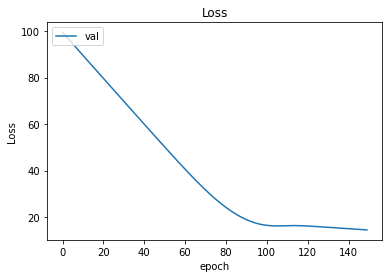

In [137]:
from matplotlib import pyplot as plt

#plt.plot(history_model_pre_lt_mov.history['loss'])
plt.plot(history_model_pre_lt_mov.history['mean_absolute_percentage_error'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend([ 'mean_absolute_percentage_error'], loc='upper left')
plt.show()

#### Long Term Prediction using Mean squared Loss

In [141]:
history_model_pre_lt_mov_2, dLinear_pred_pre_lt_mov_2 = run_experiment_Dliner(preprocessed_downsampled_dataX_movable[:,:,:-10], preprocessed_downsampled_dataY_movable,
                                                        batch_size=10, epochs=50, use_mse=True, output_diminsion=20, validation_split=0.0, 
                                                        metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
604/604 [==============================] - 1s 2ms/step - loss: 229632.7656 - mean_absolute_percentage_error: 99.4902
Epoch 2/50
604/604 [==============================] - 1s 2ms/step - loss: 225473.3594 - mean_absolute_percentage_error: 98.4833
Epoch 3/50
604/604 [==============================] - 1s 2ms/step - loss: 221369.9844 - mean_absolute_percentage_error: 97.4846
Epoch 4/50
604/604 [==============================] - 1s 2ms/step - loss: 217315.2656 - mean_absolute_percentage_error: 96.4872
Epoch 5/50
604/604 [==============================] - 1s 2ms/step - loss: 213304.2656 - mean_absolute_percentage_error: 95.4935
Epoch 6/50
604/604 [==============================] - 1s 2ms/step - loss: 209339.8906 - mean_absolute_percentage_error: 94.4976
Epoch 7/50
604/604 [==============================] - 1s 2ms/step - loss: 205418.5781 - mean_absolute_percentage_error: 93.5047
Epoch 8/50
604/604 [==============================] - 1s 1ms/step - loss: 201539.0781 - mean_absolute_pe

In [160]:
history_model_pre_lt_mov_2.history['loss']
dlinear_pred = dLinear_pred_pre_lt_mov_2.predict(preprocessed_downsampled_dataX_movable[:,:,:-10])
dlinear_model_npss = Metrics().NPSS(preprocessed_downsampled_dataY_movable, dlinear_pred)
dlinear_model_mpjpe = Metrics().MPJPE2(preprocessed_downsampled_dataY_movable, dlinear_pred,number_of_joints=34)

print('Model 14:\nNPSS: {}\nMPJPE: {}'.format(dlinear_model_npss, dlinear_model_mpjpe))

Model 14:
NPSS: 0.006095467133791247
MPJPE: 2166.3537888785863


## Loss Graphs

## Visualization

### Short Term visualization

In [131]:
dLinear_pred = dLinear_pred_pre_st_mov.predict(preprocessed_downsampled_dataX_shortterm_movable[:,:,:-10])

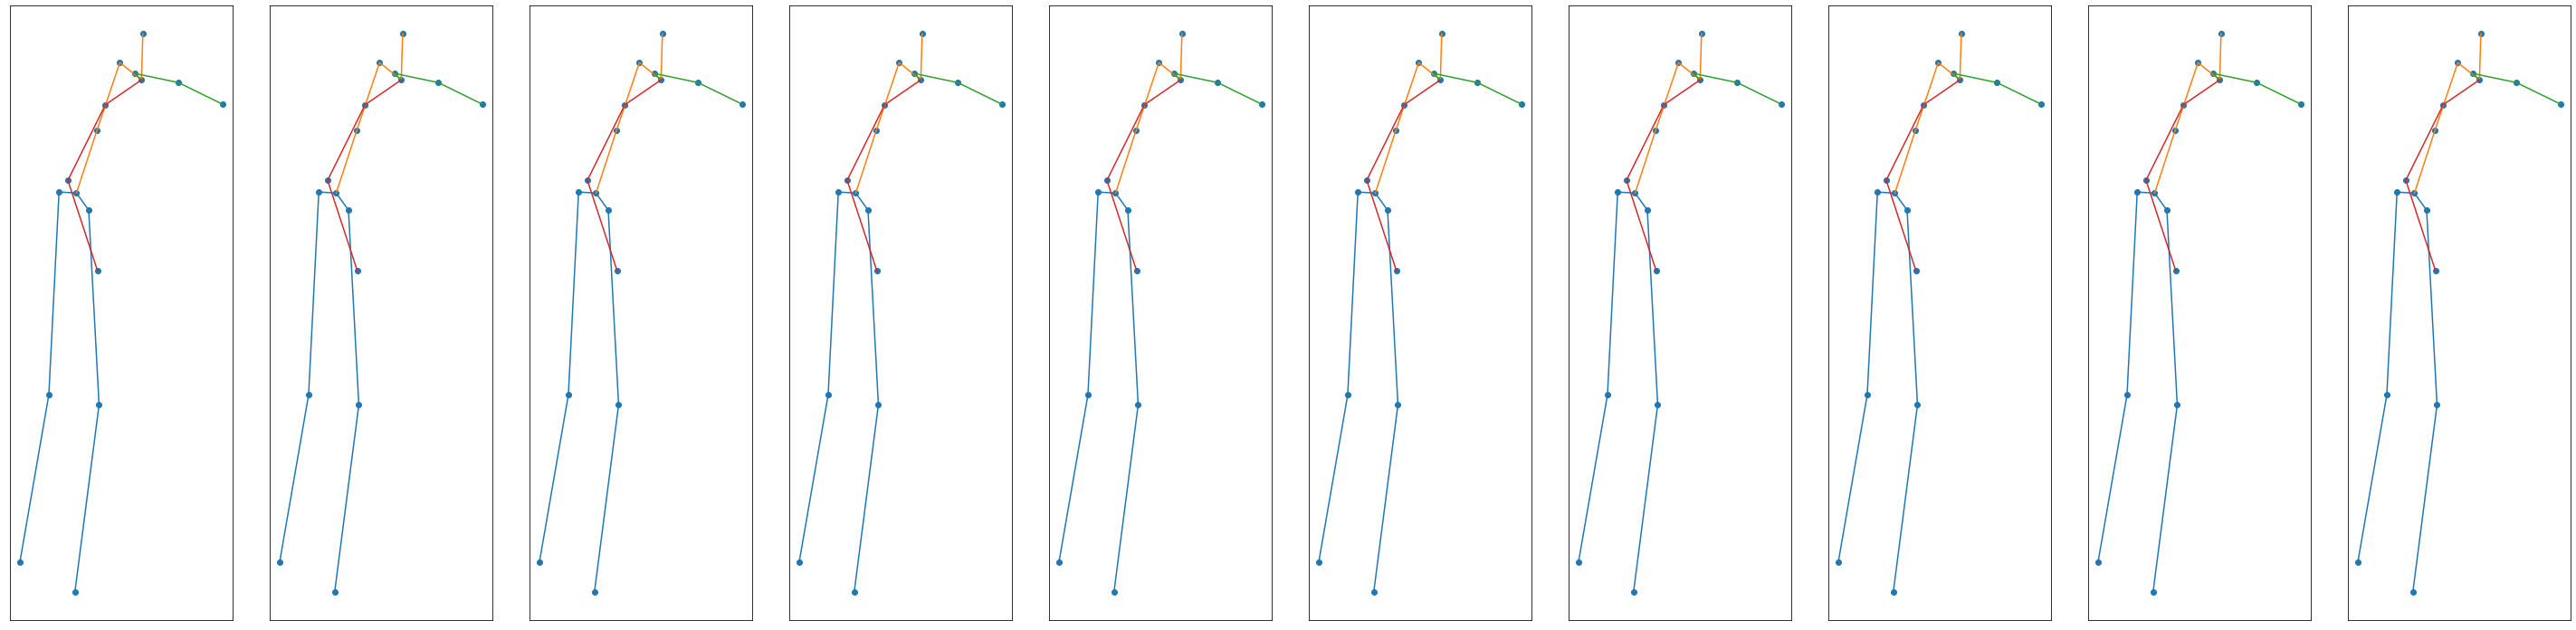

In [132]:
visualize_frames(dLinear_pred[400], dynamic_joints_only=True)

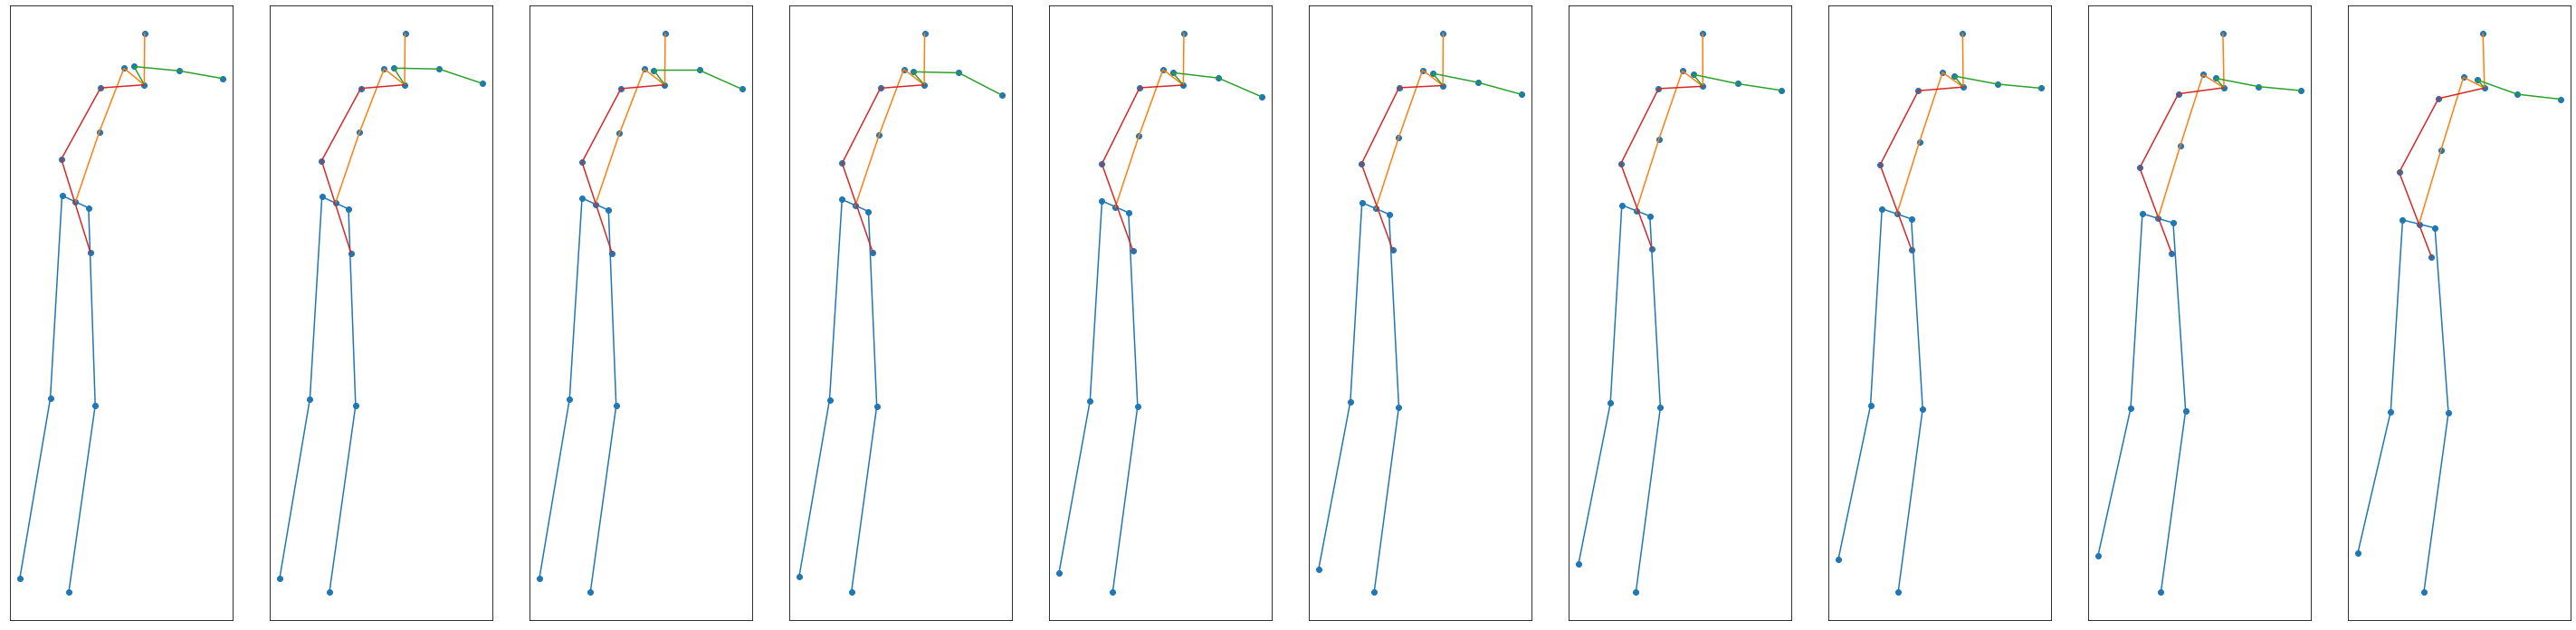

In [133]:
visualize_frames(preprocessed_downsampled_dataX_shortterm_movable[400], dynamic_joints_only=True)

### Long term Visualization

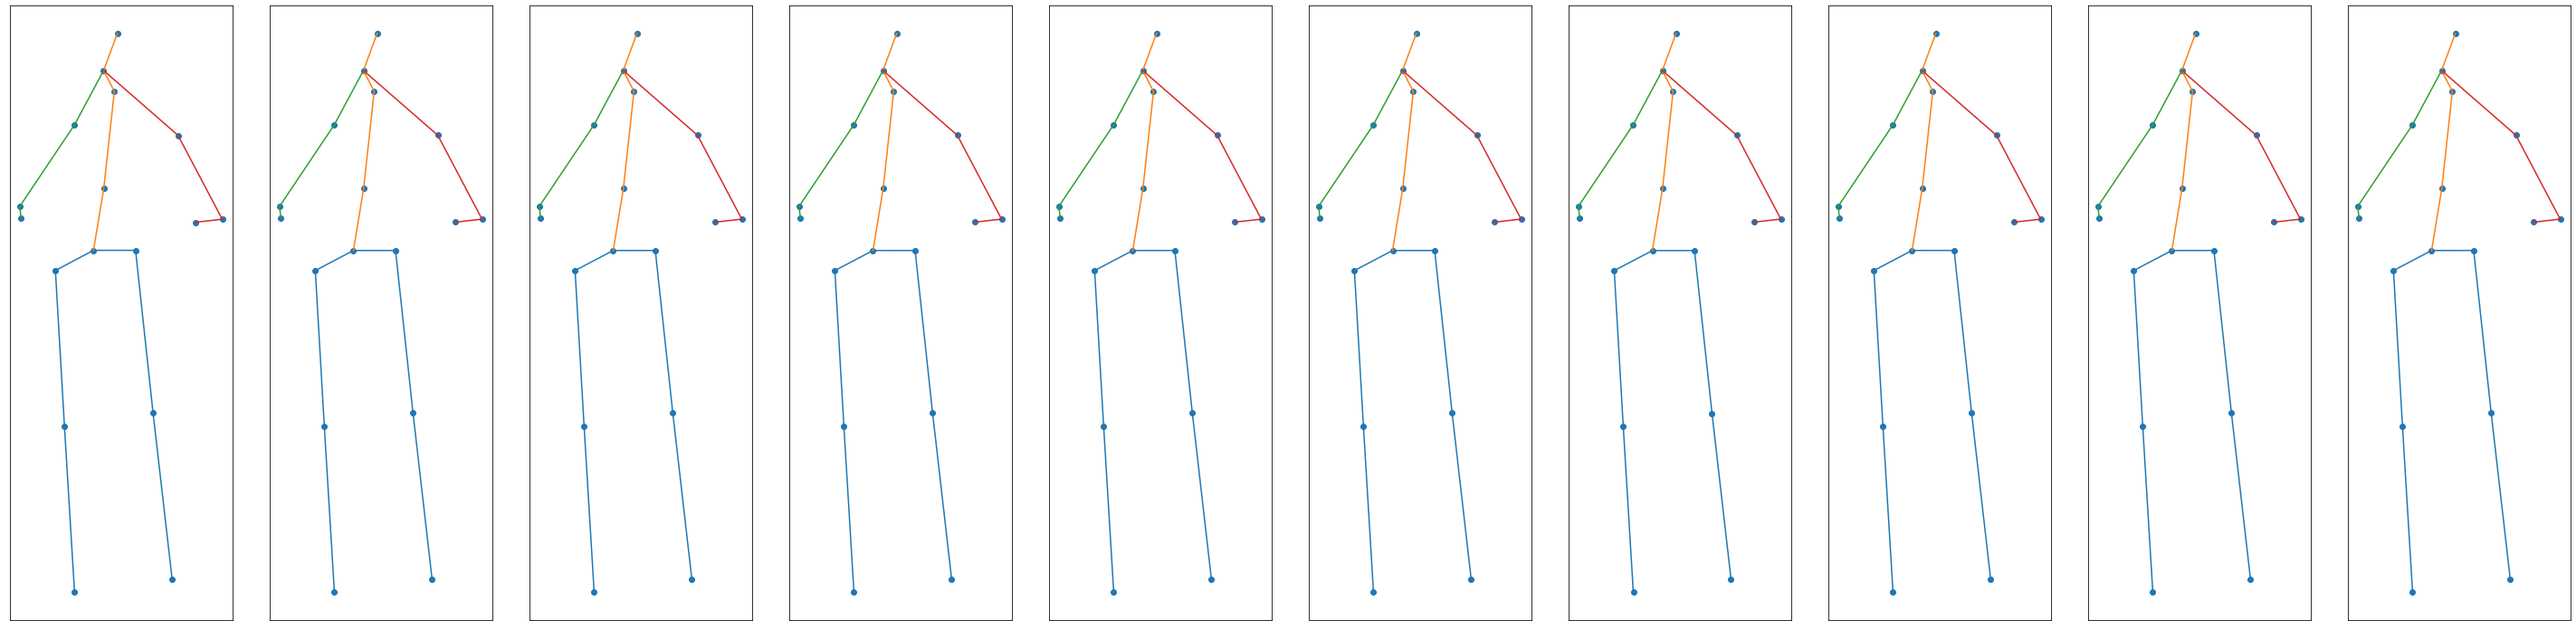

In [134]:
dLinear_pred_2 = dLinear_pred_pre_lt_mov.predict(preprocessed_downsampled_dataX_movable[:,:,:-10])
visualize_frames(dLinear_pred_2[400], dynamic_joints_only=True)

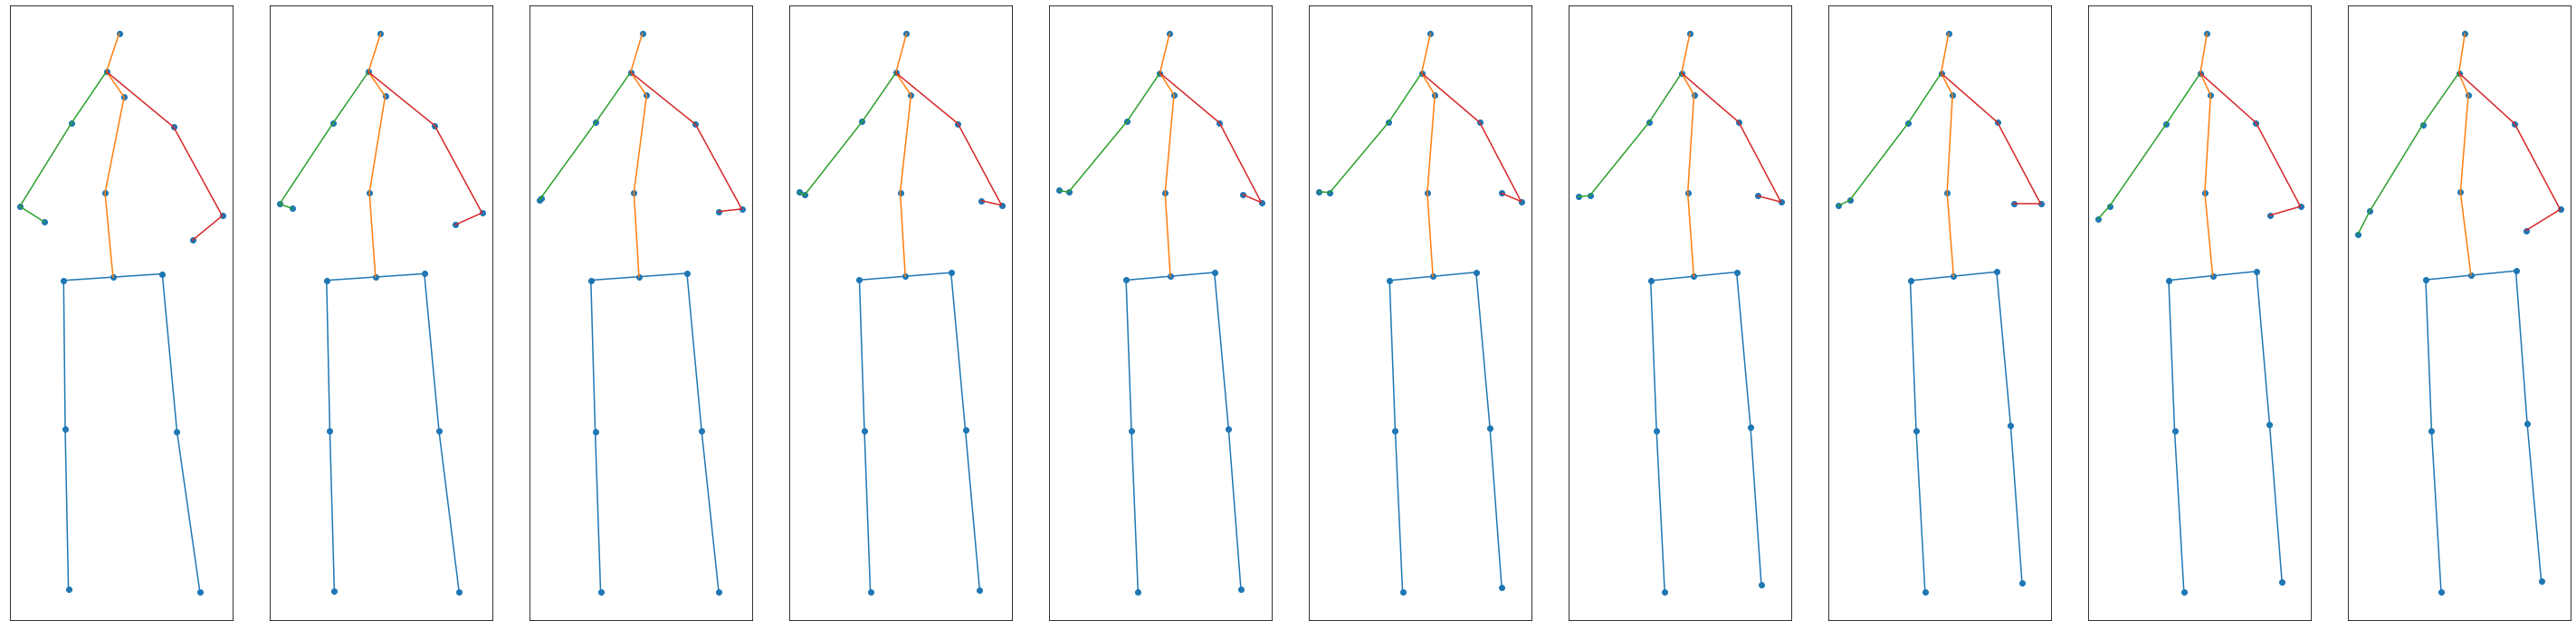

In [135]:
visualize_frames(preprocessed_downsampled_dataX_movable[400], dynamic_joints_only=True)

# References

[1] https://github.com/una-dinosauria/3d-pose-baseline/blob/master/src/data_utils.py

[2] Gopalakrishnan, Anand, et al. "A neural temporal model for human motion prediction." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2019

[3] https://github.com/cr7anand/neural_temporal_models